# Slice and dice FathomNet at family level
## Oct. 2022
Explore the structure of FathomNet to decide on dataset splits for DUDs paper. This note book looks at a coarser representation of the available benthic taxonomy at the family level.

In [1]:
import os
import sys
import glob
import datetime
import requests
import json
import progressbar
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.spatial.distance import braycurtis
from utils.regions import mbari_regions
from utils.distances import *
from utils.plotting import heatmap

Load in the benthic concept names for use down the line if downloads are needed from FathomNet.

In [2]:
with open('benthic_concepts_pared.txt', 'r') as ff:
    concepts = list(ff)
    ff.close()

concepts = [line.strip() for line in concepts]

Now get the mapping of the lowest available concept to the family level. Run the following block of code if you need to get the mapping by pinging the Deep Sea Guide. It looks at the concept hierarchy for each concept in the list. If a family level designation doesn't exists, it uses the super- or sub-family designation. If those don't exist, it uses the closest available node of the tree above family. 

In [3]:
# RUN THIS CELL IF RETRIVAL NEEDED

# lookup = {line: None for line in concepts}

# level = 'family'  # what level of the tree you want

# taxas = ['superkingdom', 'kingdom', 'phylum', 'subphylum', 'superclass', 'class', 'subclass', 'infraclass',
#          'superorder', 'order', 'suborder', 'infraorder', 'superfamily', 'family', 'subfamily', 'supergenus',
#          'genus', 'subgenus', 'species', 'subspecies']  # all possible levels of the tree

# dd = taxas.index(level)  # the index of the desired level in the list of all levels

# probs = []  # a place holder for any concepts the break the logic

# # iterate over the desired concepts
# for kk in lookup.keys():
#     try:
#         req = requests.get(f'http://m3.shore.mbari.org/kb/v1/phylogeny/basic/{kk}')
#         dox = json.loads(req.content)
#         dox = [line for line in dox if 'rank' in line.keys()]  # remove nontaxonomic lines
#         dox = [line for line in dox if line['rank'] != 'tribe']  # remove whatever tribe is


#         rank_ind = [taxas.index(item['rank']) for item in dox]  # indices of available ranks in list of all taxonoimc ranks
#         difs = np.array(rank_ind) - dd  # differences between those indicies and the index of the desired level
#         ind = list(difs).index(max(difs[difs<=0]))  # the index of the least negative number or zero
#         lookup[kk] = [line['name'] for line in dox if line['rank'] == taxas[rank_ind[ind]]][0]  # the name at that index

#     # catch anything that breaks it
#     except AttributeError:
#         print(f'problem with {kk}')
#         probs.append(kk)

# for line in probs:
#     lookup.pop(line)

# lookup = pd.DataFrame(zip(lookup.keys(), lookup.values()), columns=['lowest', level])
# lookup.to_csv('lowest2family_221810.csv')

In [4]:
# RUN THIS IF LOADING LOOKUP FROM DISK
lookup = pd.read_csv('lowest2family_221810.csv')

## By time
Generate plots by year of localizations

In [5]:
df = pd.read_csv('old/benthic_concepts_per_year.csv', index_col=0)

# drop any rows that may have caused problems when constructing the lookup table
for item in df.index.to_list():
    if item not in lookup['lowest'].to_list():
        df.drop(item, inplace=True)

# add the column of family level representations
df['family'] = df.index.to_series().map(lambda xx: lookup.loc[lookup['lowest']==xx]['family'].values[0])

# combine the rows and reset the index
df = df.groupby(['family']).sum().reset_index()
df.set_index('family', inplace=True)

## By concept
Look at the concept distribution of all the family level data

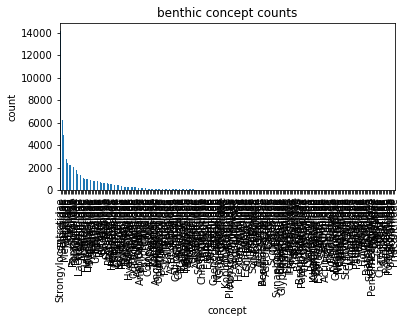

In [6]:
fig, ax = plt.subplots()
df.sum(axis=1).sort_values(ascending=False).plot(kind='bar', 
                                                 title='benthic concept counts', 
                                                 xlabel='concept', 
                                                 ylabel='count', 
                                                 ax=ax)
fig.subplots_adjust(bottom=0.3)

So long-tailed. Now just look at the concepts that have more than 100 localizations.

(76,)


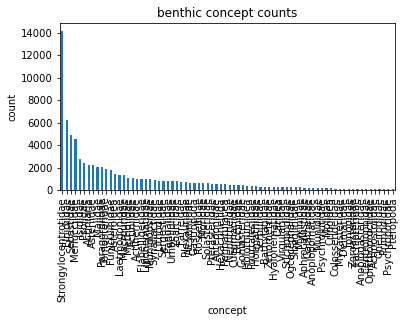

In [7]:
fig, ax = plt.subplots()
tmp = df.sum(axis=1).sort_values(ascending=False)
tmp[tmp > 100].plot(kind='bar', 
                    title='benthic concept counts', 
                    xlabel='concept', 
                    ylabel='count', 
                    ax=ax)
fig.subplots_adjust(bottom=0.3)

print(tmp[tmp > 100].shape)

There are still 76 concepts with more than 100 localizations. Maybe setting 200 as the threshold will be more legible.

(57,)


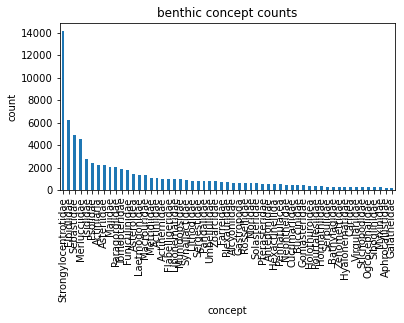

In [8]:
fig, ax = plt.subplots()
tmp = df.sum(axis=1).sort_values(ascending=False)
tmp[tmp > 200].plot(kind='bar', 
                    title='benthic concept counts', 
                    xlabel='concept', 
                    ylabel='count', 
                    ax=ax)
fig.subplots_adjust(bottom=0.3)

print(tmp[tmp > 200].shape)

There are still 57 family level concepts with more than 200 annotations. 

## By region

Divide the data up by geographic region according to coordinates availabe in the DSG (derived sort of hackily from the [data panel for Nanomia bijuga](http://dsg.mbari.org/dsg/plots/concept/Nanomia%20bijuga/Davidson%20Seamount)). Here are the regions, with `ca_borderland` `max-latitude` adjusted to 35.38 from 37.6 to avoid overlap with `great_mb`:

In [9]:
regions, regions_df = mbari_regions()

regions_df

,max-latitude,min-latitude,max-longitude,min-longitude
ca_borderland,35.38,32.58,-117.2,-122.7
davidson_seamount,35.9,35.5,-122.5,-122.9
eel_river,40.789,40.07,-124.25,-125.105
great_mb,37.199,35.38,-121.0046,-123.8479
gpg_seamounts,37.6,36.82,-123.15,-123.61
goc,32.37,22.496,-106.498,-116.332
hi,23.4,18.25,-154.2,-161.27
jdf,46.16,44.3,-129.75,-130.67
mars,36.714,36.707,-122.182,-122.192
mb,37.0538,36.4458,-121.7805,-122.5073


Some notes regarding regions:
- `mars` is data from around the cabled observatory that MBARI manages. Those coordinates are inside the `mb` region. Worth investigating if those are camera trap images or ones collected by an ROV.
- `station_m` is inside the area described by `ca_borderland`. Worth investigating if those are camera trap images or ones collected by an ROV.
- `mb` is inscribed in `greater_mb`. All images collected in `mb` are also represented in `great_mb`

This next cell can take awhile to run (~11 minutes). The output CSV is saved in this repo for easy access. 

In [10]:
# RUN THIS CELL IF RETRIVAL NEEDED

# from fathomnet.models import GeoImageConstraints
# from fathomnet.api import images, boundingboxes
# from tqdm import notebook

# inds = pd.MultiIndex.from_product([concepts, ['images', 'bboxes']], names=['concept','count-type'])  # for multi index array
# df = pd.DataFrame(columns=regions_df.index, index=inds)

# # iterate over regions
# for ii in notebook.tqdm(df.columns.to_list(), desc='regions'):
#     #iterate over concepts  
#     for cc in notebook.tqdm(concepts, desc=f'concepts in {ii}', leave=False):
#         tmp = GeoImageConstraints(concept=cc,
#             maxLatitude=regions_df.at[ii, 'max-latitude'],
#             minLatitude=regions_df.at[ii, 'min-latitude'],
#             maxLongitude=regions_df.at[ii, 'max-longitude'],
#             minLongitude=regions_df.at[ii, 'min-longitude']
#         )

#         # get the relevant images from region
#         imgs = images.find(tmp)

#         # get the number of bounding boxes in those images
#         numbox = 0
#         for im in imgs:
#             numbox += len(list(filter(lambda box: box.concept == cc, im.boundingBoxes)))

#         # set values in array
#         df.loc[(cc, 'images'), ii] = len(imgs)  # number of images with the concept
#         df.loc[(cc, 'bboxes'), ii] = numbox  # number of bboxes in those images

# # save to this directory
# df.sort_index()
# df.to_csv('benthic_counts_region.csv')

In [11]:
# RUN THIS CELL TO LOAD REGION COUNTS FROM DISK
df = pd.read_csv('benthic_counts_region.csv')

Combine use the lookup table to combine rows, etc

In [12]:
# drop any rows that may have caused problems when constructing the lookup table
for item in list(set(df['concept'].to_list())):
    if item not in lookup['lowest'].to_list():
        df.drop(df.loc[df['concept']==item].index, inplace=True)

# add the column of family level representations
df['family'] = df['concept'].map(lambda xx: lookup.loc[lookup['lowest']==xx]['family'].values[0])

# # combine the rows and reset the index
df = df.groupby(['family', 'count-type']).sum()

Print out the images, bounding boxes, and concepts per region

In [13]:
df = df.sort_index()  # sort index if not already

# print the counts of each type in each region and number of concepts
pd.DataFrame((df.xs("images", level="count-type").sum(), 
    df.xs("bboxes", level="count-type").sum(),
    df.xs("bboxes", level="count-type")[df.xs("bboxes", level="count-type") != 0].count()), 
    index=["images","bboxes","num-concepts"]
).T

,images,bboxes,num-concepts
ca_borderland,3118,6734,94
davidson_seamount,1163,1436,78
eel_river,271,669,34
great_mb,30977,59145,186
gpg_seamounts,480,730,49
goc,2924,4258,110
hi,136,145,35
jdf,395,470,36
mars,949,2614,41
mb,20476,44076,156


### Distances between regions

Grab the bounding boxes for this.

In [14]:
tmp = df.xs("bboxes", level="count-type")
tmp = tmp.drop('taney_seamount', axis=1)  # drop Taney Seamount since there are no labels

#### Bray-Curtis dissimilarity 
Use [Bray-Curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) (BC) dissimilarity to quantify how different the regions are taxonomically. BC is bounded \[0,1\] with 0 suggesting the regions are taxonomically identical and 1 suggesting there is no species overlap.d

Text(0.5, 1.0, 'ordered by longitude')

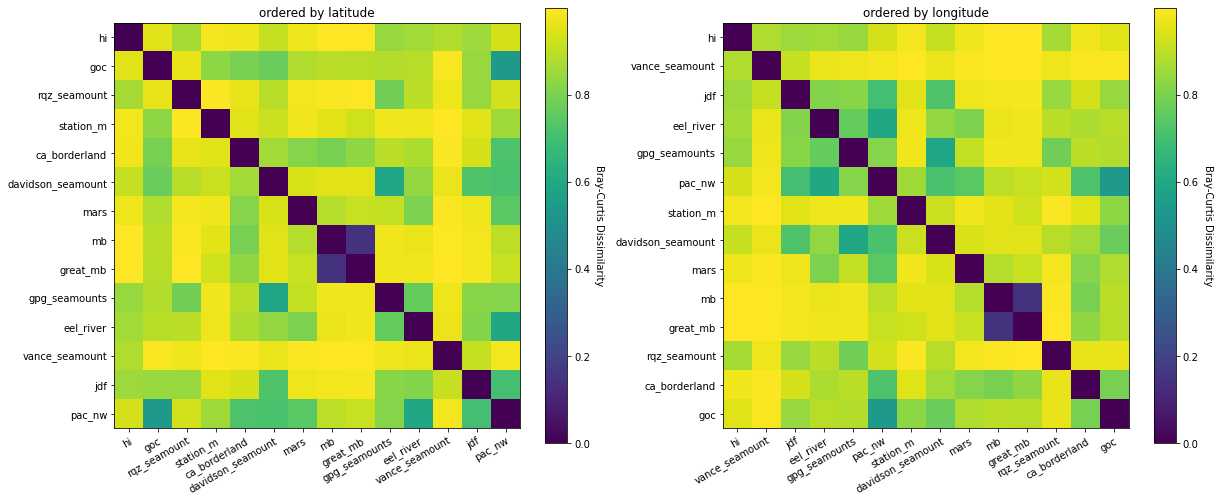

In [15]:
# make two plots, one ordered by latitude the other by longitude
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# reorder the indicies by latitude
ordercol = regions_df.sort_values('max-latitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

outbc = pairwise_bc(tmp)
im, cbar = heatmap(outbc.to_numpy(), 
    row_labels=outbc.columns.to_list(), 
    col_labels=outbc.columns.to_list(), 
    ax=ax[0], 
    cmap='viridis'
)
cbar.ax.set_ylabel('Bray-Curtis Dissimilarity', rotation=-90, va="bottom")
ax[0].set_title('ordered by latitude')

#
ordercol = regions_df.sort_values('max-longitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

outbc = pairwise_bc(tmp)
im, cbar = heatmap(outbc.to_numpy(), 
    row_labels=outbc.columns.to_list(), 
    col_labels=outbc.columns.to_list(), 
    ax=ax[1], 
    cmap='viridis'
)
cbar.ax.set_ylabel('Bray-Curtis Dissimilarity', rotation=-90, va="bottom")
ax[1].set_title('ordered by longitude')

#### L1 distance between normalized distribution
Compute the L1 distance between the normalized per-concept distribtuion in each region. This is akin to the computation make in [Beery et al., 2022](https://openaccess.thecvf.com/content/CVPR2022/papers/Beery_The_Auto_Arborist_Dataset_A_Large-Scale_Benchmark_for_Multiview_Urban_CVPR_2022_paper.pdf) to look at the distance between tree class distributions. Unfortunately, the concepts in our benthic list are not all at the same level of the taxonomic tree so these calculations are not exactly one-to-one with Sara's paper. 

Text(0.5, 1.0, 'ordered by longitude')

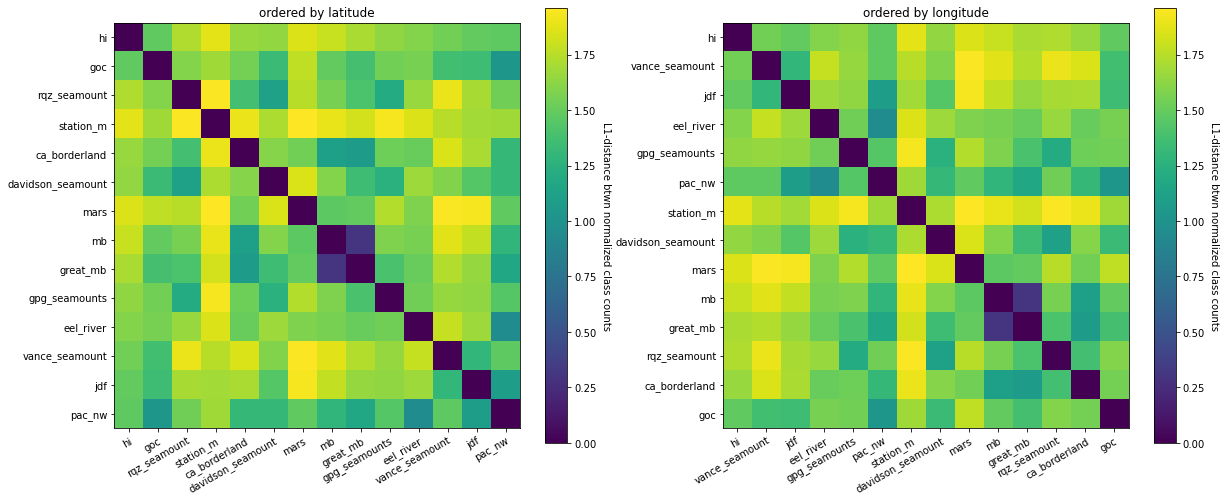

In [16]:
# make two plots, one ordered by latitude the other by longitude
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# reorder the indicies by latitude
ordercol = regions_df.sort_values('max-latitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

outL1 = pairwise_L1_dist(tmp)

im, cbar = heatmap(outL1.to_numpy(), 
    row_labels=outL1.columns.to_list(), 
    col_labels=outL1.columns.to_list(), 
    ax=ax[0], 
    cmap='viridis'
)
cbar.ax.set_ylabel('L1-distance btwn normalized class counts', rotation=-90, va="bottom")
ax[0].set_title('ordered by latitude')

# reorder the indicies by longitude
ordercol = regions_df.sort_values('max-longitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

outL1 = pairwise_L1_dist(tmp)
im, cbar = heatmap(outL1.to_numpy(), 
    row_labels=outL1.columns.to_list(), 
    col_labels=outL1.columns.to_list(), 
    ax=ax[1], 
    cmap='viridis'
)
cbar.ax.set_ylabel('L1-distance btwn normalized class counts', rotation=-90, va="bottom")
ax[1].set_title('ordered by longitude')

### Mutual information

Text(0.5, 1.0, 'ordered by longitude')

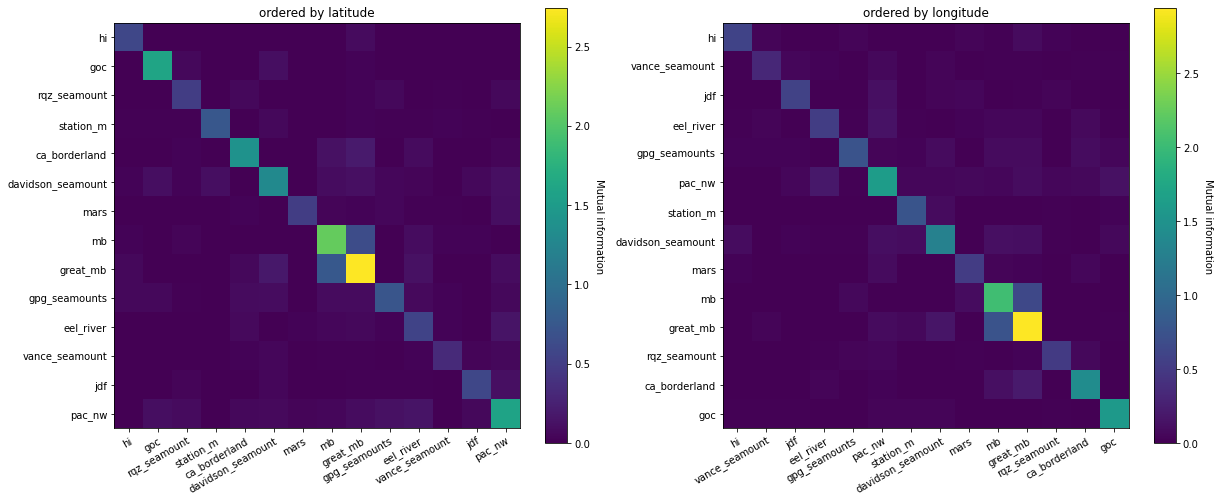

In [17]:
# make two plots, one ordered by latitude the other by longitude
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# reorder the indicies by latitude
ordercol = regions_df.sort_values('max-latitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

outmi = pairwise_mi(tmp)

im, cbar = heatmap(outmi.to_numpy(), 
    row_labels=outmi.columns.to_list(), 
    col_labels=outmi.columns.to_list(), 
    ax=ax[0], 
    cmap='viridis'
)
cbar.ax.set_ylabel('Mutual information', rotation=-90, va="bottom")
ax[0].set_title('ordered by latitude')

#reorder the indicies by longitude
ordercol = regions_df.sort_values('max-longitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

outmi = pairwise_mi(tmp)

im, cbar = heatmap(outmi.to_numpy(), 
    row_labels=outmi.columns.to_list(), 
    col_labels=outmi.columns.to_list(), 
    ax=ax[1], 
    cmap='viridis'
)
cbar.ax.set_ylabel('Mutual information', rotation=-90, va="bottom")
ax[1].set_title('ordered by longitude')

### Dice coefficent

Binarize the data and use Dice to quanitify the overlap in the presence of organisms in the different regions

Text(0.5, 1.0, 'ordered by longitude')

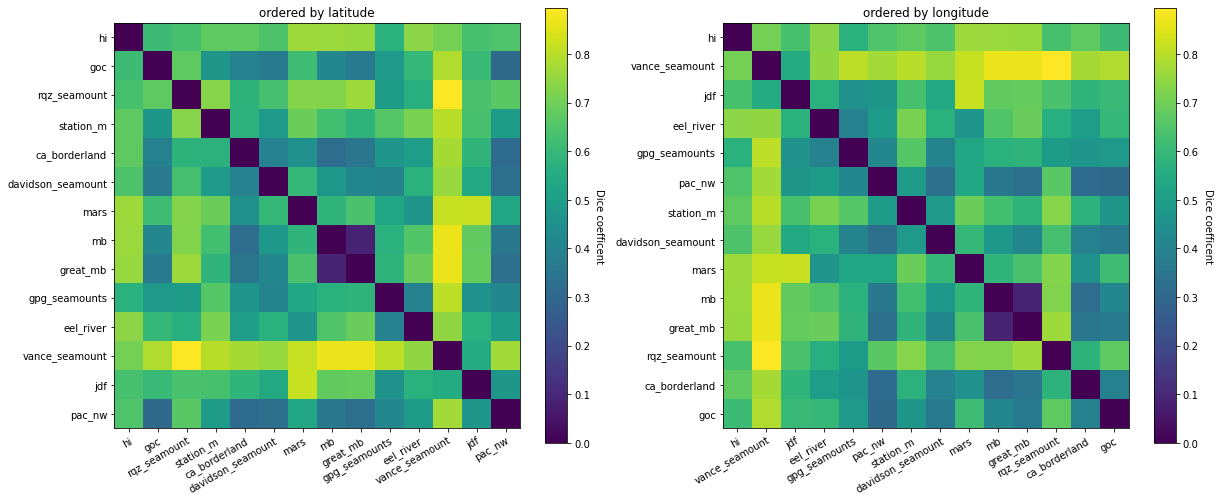

In [18]:
# make two plots, one ordered by latitude the other by longitude
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# reorder the indicies by latitude
ordercol = regions_df.sort_values('max-latitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

dd = pairwise_dice(tmp)

im, cbar = heatmap(dd.to_numpy(), 
    row_labels=dd.columns.to_list(), 
    col_labels=dd.columns.to_list(), 
    ax=ax[0], 
    cmap='viridis'
)
cbar.ax.set_ylabel('Dice coefficent', rotation=-90, va="bottom")
ax[0].set_title('ordered by latitude')

# reorder the indicies by longitude
ordercol = regions_df.sort_values('max-longitude').index.to_list()
ordercol.remove('taney_seamount')
tmp = tmp[ordercol]

dd = pairwise_dice(tmp)
im, cbar = heatmap(dd.to_numpy(), 
    row_labels=dd.columns.to_list(), 
    col_labels=dd.columns.to_list(), 
    ax=ax[1], 
    cmap='viridis'
)
cbar.ax.set_ylabel('Dice coefficent', rotation=-90, va="bottom")
ax[1].set_title('ordered by longitude')

## By depth
got to here 10/20/22. Need to deal with combining at family level for depth data 

Pull down data by depth in Monterey Bay. Once again this takes awhile since there are thousands of individual API calls happening. 

In [19]:
# RUN THIS CELL IF RETRIVAL NEEDED

# from fathomnet.models import GeoImageConstraints
# from fathomnet.api import images, boundingboxes
# from tqdm import notebook

# depths = np.arange(0,4100,100, dtype=np.float64)  # depth horizons in meters

# inds = pd.MultiIndex.from_product([concepts, ['images', 'bboxes']], names=['concept','count-type'])  # for multi index array
# df = pd.DataFrame(columns=depths, index=inds)

# # iterate over depths
# for ii, vv in enumerate(notebook.tqdm(depths[0:-1], desc='regions')):
#     #iterate over concepts  
#     for cc in notebook.tqdm(concepts, desc=f'concepts in {ii}', leave=False):
#         tmp = GeoImageConstraints(concept=cc,
#             maxLatitude=regions_df.at['great_mb', 'max-latitude'],
#             minLatitude=regions_df.at['great_mb', 'min-latitude'],
#             maxLongitude=regions_df.at['great_mb', 'max-longitude'],
#             minLongitude=regions_df.at['great_mb', 'min-longitude'],
#             minDepth=depths[ii],
#             maxDepth=depths[ii+1]-0.1
#         )

#         # get the relevant images from region
#         imgs = images.find(tmp)

#         # get the number of bounding boxes in those images
#         numbox = 0
#         for im in imgs:
#             numbox += len(list(filter(lambda box: box.concept == cc, im.boundingBoxes)))

#         # set values in array
#         df.loc[(cc, 'images'), vv] = len(imgs)  # number of images with the concept
#         df.loc[(cc, 'bboxes'), vv] = numbox  # number of bboxes in those images

# # save to this directory
# df.sort_index()
# df.to_csv('gmb_counts_depth.csv')

In [20]:
# RUN THIS TO LOAD DEPTH COUNTS FROM DISK
df = pd.read_csv('gmb_counts_depth.csv')  # counts in 100-m depth bins in Greater MB

In [21]:
# drop any rows that may have caused problems when constructing the lookup table
for item in list(set(df['concept'].to_list())):
    if item not in lookup['lowest'].to_list():
        df.drop(df.loc[df['concept']==item].index, inplace=True)

# add the column of family level representations
df['family'] = df['concept'].map(lambda xx: lookup.loc[lookup['lowest']==xx]['family'].values[0])

# # combine the rows and reset the index
df = df.groupby(['family', 'count-type']).sum()

In [22]:
# print the counts of each type in each region and number of concepts
pd.DataFrame((df.xs("images", level="count-type").sum(), 
    df.xs("bboxes", level="count-type").sum(),
    df.xs("bboxes", level="count-type")[df.xs("bboxes", level="count-type") != 0].count()), 
    index=["images","bboxes","num-concepts"]
).T

,images,bboxes,num-concepts
0.0,620.0,1083.0,39.0
100.0,920.0,1697.0,40.0
200.0,1796.0,5085.0,53.0
300.0,3112.0,7064.0,64.0
400.0,2943.0,4865.0,63.0
500.0,2074.0,6372.0,63.0
600.0,2229.0,4630.0,77.0
700.0,1057.0,1893.0,67.0
800.0,2709.0,5620.0,82.0
900.0,1838.0,3112.0,75.0


In [23]:
tmp = df.xs('bboxes', level='count-type')

### Bray-Curtis

/opt/anaconda3/envs/fn_data_explore/lib/python3.9/site-packages/scipy/spatial/distance.py:1158: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


Text(0, 0.5, 'Bray-Curtis Dissimilarity')

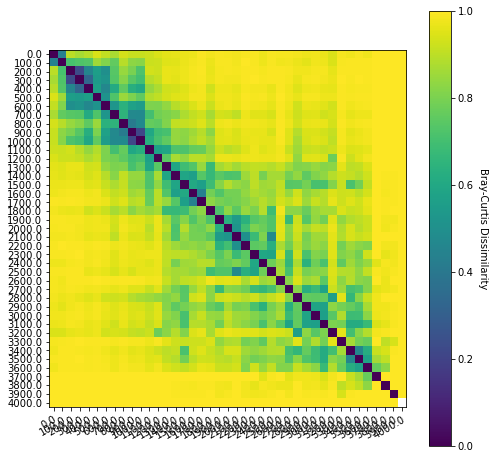

In [24]:
outbc = pairwise_bc(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outbc.to_numpy(), 
    row_labels=outbc.columns.to_list(), 
    col_labels=outbc.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('Bray-Curtis Dissimilarity', rotation=-90, va="bottom")

### L1-distance of normalized concept counts

Text(0, 0.5, 'L1-distance btwn normalized class counts')

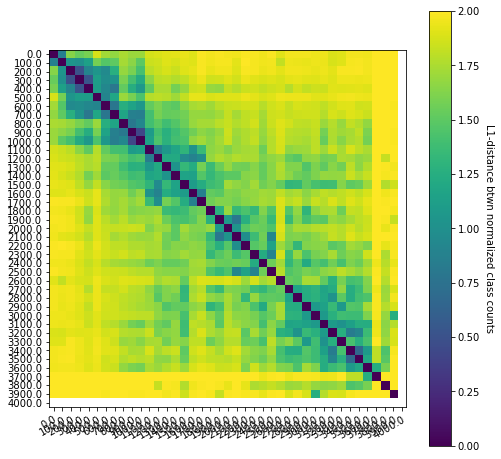

In [25]:
outL1 = pairwise_L1_dist(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outL1.to_numpy(), 
    row_labels=outL1.columns.to_list(), 
    col_labels=outL1.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('L1-distance btwn normalized class counts', rotation=-90, va="bottom")

### Dice 

/opt/anaconda3/envs/fn_data_explore/lib/python3.9/site-packages/scipy/spatial/distance.py:1420: RuntimeWarning: invalid value encountered in double_scalars
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))


Text(0, 0.5, 'Dice coefficent')

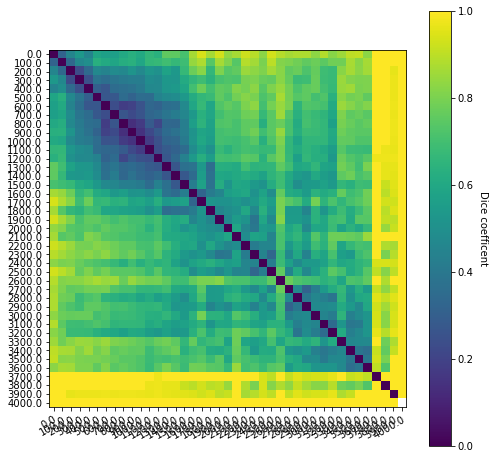

In [26]:
dd = pairwise_dice(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(dd.to_numpy(), 
    row_labels=dd.columns.to_list(), 
    col_labels=dd.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('Dice coefficent', rotation=-90, va="bottom")

## By camera

This will be sort of hacky as there currently is not a field in FathomNet for camera used to collect the image. But there are these date ranges for cameras deployed on each ROV.

| rov_name | camera_name | start_date | end_date | fov_width_pixels | fov_height_pixels |
| --- | --- | --- | --- | --- | --- |  
| Doc Ricketts | Ikegami HDL40  | 2/10/2009 12:00:00 AM | 12/31/2019 11:59:00 PM | 1920 | 1080 |
| Tiburon | Panasonic 3-chip | 10/29/1996 12:00:00 AM | 9/23/2005 11:59:00 PM | 720 | 480 |
| Tiburon | Ikegami HDL40 | 10/4/2005 12:00:00 AM | 12/20/2007 11:59:00 PM | 1920 | 1080 |
| Ventana | Sony 3-chip | 8/25/1988 12:00:00 AM | 8/25/1999 11:59:00 PM | 720 | 480 |
| Ventana | Sony HDTV | 9/3/1999 12:00:00 AM | 7/9/2007 11:59:00 PM | 1920 | 1080 |
| Ventana | Sony 3-chip | 7/11/2007 12:00:00 AM | 7/31/2007 11:59:00 PM | 720 | 480 |
| Ventana | Ikegami HDL40 | 8/2/2007 12:00:00 AM | 12/31/2019 11:59:00 PM | 1920 | 1080 |

First make the table into a dictonary.

In [27]:
cams = {'Doc%20Ricketts': {'ikegami': ['2009-02-10', '2019-12-31']},
        'Tiburon': {'panasonic': ['1996-10-29', '2005-09-23'],
                    'ikegami': ['2005-10-04', '2007-12-20']},
        'Ventana': {'sonyChip': ['2007-07-11', '2007-07-31'],
                    'sonyHD': ['1999-09-03', '2007-07-09'],
                    'ikegami': ['2008-08-02', '2019-12-31']}
       }

In [28]:
# RUN THIS CELL TO RETRIEVE COUNTS

# from fathomnet.models import GeoImageConstraints
# from fathomnet.api import images, boundingboxes
# from tqdm import notebook

# inds = pd.MultiIndex.from_product([concepts, ['images', 'bboxes']], names=['concept','count-type'])  # for multi index array
# cols = pd.MultiIndex.from_arrays([['Doc%20Ricketts', 'Tiburon', 'Tiburon', 'Ventana', 'Ventana', 'Ventana'], 
#     ['ikegami', 'panasonic','ikegami','sonyChip', 'sonyHD','ikegami']], names=['vehicle','camera'])
# df = pd.DataFrame(columns=cols, index=inds)

# for ii in (notebook.tqdm(df.columns.to_list())):
#     st_time = datetime.datetime.fromisoformat(cams[ii[0]][ii[1]][0])
#     ed_time = datetime.datetime.fromisoformat(cams[ii[0]][ii[1]][1])
#     for cc in notebook.tqdm(concepts, desc=f'concepts for {ii[0]}, {ii[1]}', leave=False):
#         tmp = GeoImageConstraints(concept=cc,
#             startTimestamp=st_time.isoformat(timespec='milliseconds') + 'Z',
#             endTimestamp=ed_time.isoformat(timespec='milliseconds') + 'Z'
#         )

#         # get the relevant images during the time frame
#         imgs = images.find(tmp)

#         # filter by vehicle name in url and count imgs and bboxes
#         numimgs = 0
#         numbox = 0
#         for im in imgs:
#             if ii[0] in im.url:
#                 numimgs += 1
#                 numbox += len(list(filter(lambda box: box.concept == cc, im.boundingBoxes)))

#         # set values in array
#         df.loc[(cc, 'images'), (ii[0], ii[1])] = numimgs  # number of images with the concept
#         df.loc[(cc, 'bboxes'), (ii[0], ii[1])] = numbox  # number of bboxes in those images

# df.sort_index()
# df.to_csv('mbari_counts_camera.csv')

In [29]:
# RUN THIS CELL TO READ FROM DISK
df = pd.read_csv('mbari_counts_camera.csv', header=[0,1], index_col=[0,1])
#df = df.swaplevel(0,1)

In [30]:
# drop any rows that may have caused problems when constructing the lookup table
for item in df.index.get_level_values('concept').to_list():
    if item not in lookup['lowest'].to_list():
        df.drop(item, level='concept', inplace=True)

# add the column of family level representations
flt = []
for item in df.index.get_level_values('concept').to_list():
    fam = lookup.loc[lookup['lowest']==item]['family'].values[0]
    flt.append(fam)

Work around for reindexing with duplicate label values per this discussion on [Pandas git project](https://github.com/pandas-dev/pandas/issues/28294)

In [31]:
df.index = df.index.set_levels([flt],level=[0], verify_integrity=False)

Summary numbers of images, bboxes, and number of concepts for each vehicle/camera

In [32]:
xx = pd.DataFrame(df.xs("images",level='count-type').sum(), columns=["images"])

xx.loc[:,'bboxes'] = df.xs("bboxes",level='count-type').sum()
xx.loc[:,"num concepts"] = df.xs("bboxes",level='count-type').groupby(level=0).sum()[df.xs("bboxes",level='count-type').groupby(level=0).sum() != 0].count()

xx

images  bboxes  num concepts
vehicle        camera                                 
Doc%20Ricketts ikegami     25822   44503           116
Tiburon        panasonic    4365    6850            89
               ikegami      2382    3260            75
Ventana        sonyChip        4       4             2
               sonyHD       3501    6851            63
               ikegami      8158   18588            85

Just look at bboxes and flattern the columns

In [33]:
tmp = df.xs("bboxes", level='count-type')
tmp = tmp.groupby(level=0).sum()
tmp.columns = tmp.columns.to_flat_index()
tmp.pop(tmp.columns[3])
tmp

,"(Doc%20Ricketts, ikegami)","(Tiburon, panasonic)","(Tiburon, ikegami)","(Ventana, sonyHD)","(Ventana, ikegami)"
concept,,,,,
Abyssochrysoidea,15,10,0,0,6
Acanthuridae,4,1,2,0,1
Actinernidae,11,0,0,3,7
Actiniaria,54,3,10,0,0
Actiniidae,152,42,24,50,147
...,...,...,...,...,...
Tritoniidae,215,52,5,46,6
Volutidae,1493,219,95,401,660
Zanclidae,514,0,0,0,0


### Bray-Curtis

Text(0, 0.5, 'Bray-Curtis Dissimilarity')

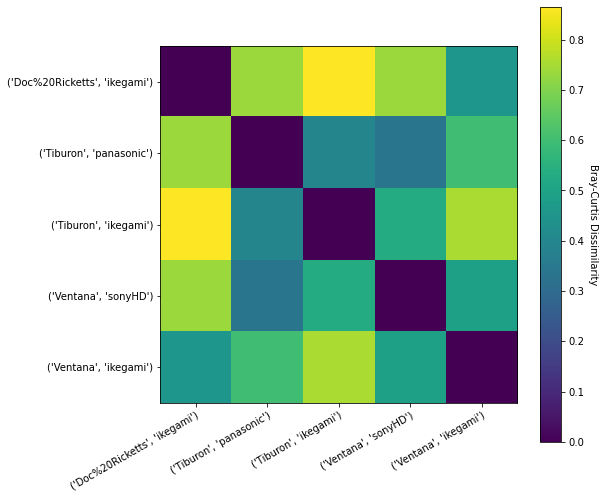

In [34]:
outbc = pairwise_bc(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outbc.to_numpy(), 
    row_labels=outbc.columns.to_list(), 
    col_labels=outbc.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('Bray-Curtis Dissimilarity', rotation=-90, va="bottom")

### L1-distance of normalized concept counts

Text(0, 0.5, 'L1-distance btwn normalized class counts')

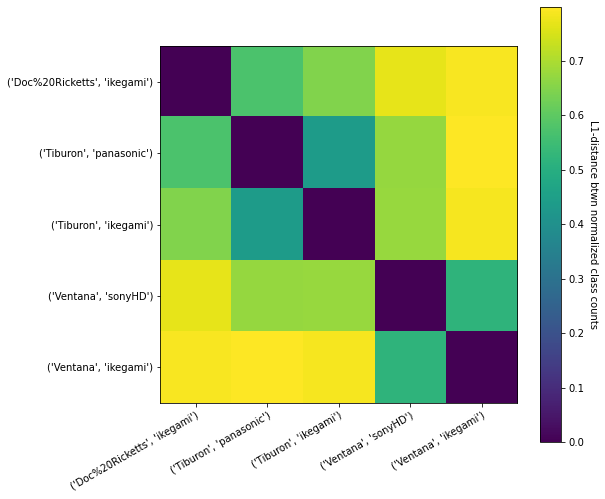

In [35]:
outL1 = pairwise_L1_dist(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outL1.to_numpy(), 
    row_labels=outL1.columns.to_list(), 
    col_labels=outL1.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('L1-distance btwn normalized class counts', rotation=-90, va="bottom")

### Dice 

Text(0, 0.5, 'Dice coefficent')

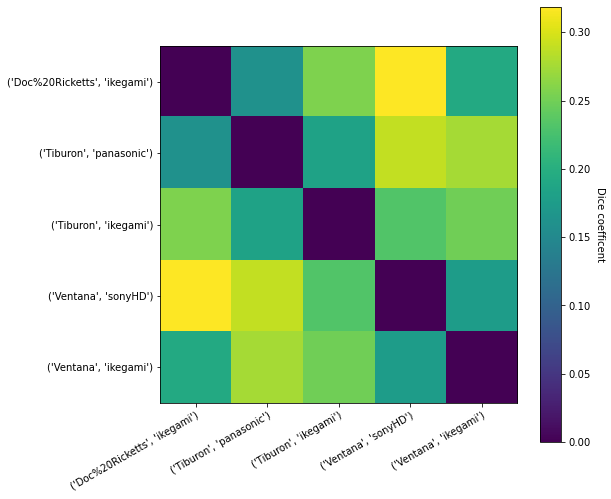

In [36]:
dd = pairwise_dice(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(dd.to_numpy(), 
    row_labels=dd.columns.to_list(), 
    col_labels=dd.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('Dice coefficent', rotation=-90, va="bottom")